In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import tensorflow as tf

In [2]:
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')


In [3]:
# read data
train = pd.read_csv('./data/train.txt', delimiter=';', header=None, names=['data', 'label'])
test = pd.read_csv('./data/test.txt', delimiter=';', header=None, names=['data', 'label'])
val = pd.read_csv('./data/val.txt', delimiter=';', header=None, names=['data', 'label'])
comb_data = pd.concat([train, val, test])
comb_data.shape

(20000, 2)

In [4]:
le = LabelEncoder()
comb_data['label_enc'] = le.fit_transform(comb_data['label'])
comb_data.head()

,data,label,label_enc
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,4
2,im grabbing a minute to post i feel greedy wrong,anger,0
3,i am ever feeling nostalgic about the fireplac...,love,3
4,i am feeling grouchy,anger,0


In [5]:
def tokenize_data(df):
    sents = df['data']
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    tokens = []
    for i in sents:
        tokens.append(tokenizer.tokenize(i.lower()))
    return tokens
tokenized = tokenize_data(comb_data)

In [6]:
def remove_stopwords(tokenized):
    sw = set(stopwords.words('english'))
    sw_removed = []
    for sent in tokenized:
        filtered = []
        for word in sent:
            if word not in sw:
                filtered.append(word)
        sw_removed.append(filtered)
    return sw_removed
stopwords_removed = remove_stopwords(tokenized)

In [7]:
def lemmatize(processed):
    lemma = WordNetLemmatizer()
    lemmatized = []
    for sent in processed:
        filtered = []
        for word in sent:
            filtered.append(lemma.lemmatize(word, pos='v'))
        lemmatized.append(filtered)
    return lemmatized
lemmatized = lemmatize(stopwords_removed)

In [8]:
final_data = []
# each l is a list of processed words
for l in lemmatized:
    final_data.append(' '.join(l))
d = {'data': final_data, 'label': comb_data['label_enc'], 'label_raw': comb_data['label']}
final_df = pd.DataFrame(data=d)

In [9]:
final_df.head()

,data,label,label_raw
0,didnt feel humiliate,4,sadness
1,go feel hopeless damn hopeful around someone c...,4,sadness
2,im grab minute post feel greedy wrong,0,anger
3,ever feel nostalgic fireplace know still property,3,love
4,feel grouchy,0,anger


In [10]:
from sklearn.model_selection import train_test_split
def prepare_dataset(df, test_size=0.2, seq_len=30, embedding_dim=100):
    xtrain, xtest, ytrain, ytest = train_test_split(df['data'], df['label'], test_size=test_size, random_state=42)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df['data'])
    word_inds = tokenizer.word_index
    vocab_size = len(word_inds) + 1

    ytrain = tf.keras.utils.to_categorical(ytrain, dtype='uint8')
    ytest = tf.keras.utils.to_categorical(ytest, dtype='uint8')

    xtrain = pad_sequences(tokenizer.texts_to_sequences(xtrain), maxlen=seq_len)
    xtest = pad_sequences(tokenizer.texts_to_sequences(xtest), maxlen=seq_len)
    print('x: ', xtrain.shape)
    print(xtest.shape)
    print('y: ', ytrain.shape)
    print(ytest.shape)
    print(vocab_size)
    return xtrain, xtest, ytrain, ytest, vocab_size

xtrain, xtest, ytrain, ytest, vocab_size = prepare_dataset(final_df)

x:  (16000, 30)
(4000, 30)
y:  (16000, 6)
(4000, 6)
13660


## CNN classifier

In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv1D, Dense, GlobalMaxPooling1D, MaxPooling1D, Dropout, Embedding, Input, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.python.ops.gen_batch_ops import batch

In [12]:
class CNN:
    def __init__(self, vocab_size, batch_size=256, epochs=20, embedding_dim=100, seq_len=30):
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size
        self.epochs = epochs
        self.seq_len = seq_len
        self.early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=0)
        self.reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=0.000001, verbose=0)
        self.model = self.build_model(vocab_size)

    def build_model(self, vocab_size):
        inputs = Input(shape=(self.seq_len,), dtype=np.int32)
        embedding = Embedding(input_dim=vocab_size, output_dim=self.embedding_dim, input_length=self.seq_len, trainable=True)
        model = embedding(inputs)
        model = Dropout(0.2)(model)

        # conv block 1
        model = Conv1D(128, 3, activation='relu')(model)
        model = Conv1D(128, 3, activation='relu')(model)
        model = MaxPooling1D()(model)

        # conv block 2
        model = Conv1D(64, 3, activation='relu')(model)
        model = Conv1D(64, 3, activation='relu')(model)
        model = Dropout(0.2)(model)

        # conv block 3
        model = Conv1D(64, 3, activation='relu')(model)
        model = Conv1D(32, 3, activation='relu')(model)
        model = GlobalMaxPooling1D()(model)

        # FC
        model = BatchNormalization()(model)
        model = Dense(512, activation='relu')(model)
        model = Dense(128, activation='relu')(model)
        model = Dropout(0.2)(model)

        # output
        outputs = Dense(6, activation='softmax')(model)
        return tf.keras.Model(inputs, outputs, name='cnn')

    def summary(self):
        return self.model.summary()

    def train(self, xtrain, xtest, ytrain, ytest):
        opt = Adam(learning_rate=0.01)
        self.model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
        history = self.model.fit(xtrain, ytrain, batch_size=self.batch_size, epochs=self.epochs, validation_data=(xtest, ytest), callbacks=[self.reduce_lr], verbose=1)
        return history

    def predict(self, data):
        # assume data is already cleaned
        return self.model.predict(data)

In [13]:
cnn = CNN(vocab_size)
history = cnn.train(xtrain, xtest, ytrain, ytest)

Epoch 1/20
63/63 [==============================] - 8s 19ms/step - loss: 1.4375 - accuracy: 0.4370 - auc: 0.7763 - val_loss: 3.6078 - val_accuracy: 0.4392 - val_auc: 0.6945
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 0.9666 - accuracy: 0.6379 - auc: 0.9062 - val_loss: 2.1072 - val_accuracy: 0.4888 - val_auc: 0.7708
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 0.8209 - accuracy: 0.6911 - auc: 0.9324 - val_loss: 1.6294 - val_accuracy: 0.3525 - val_auc: 0.7944
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 0.6825 - accuracy: 0.7526 - auc: 0.9531 - val_loss: 0.8374 - val_accuracy: 0.6777 - val_auc: 0.9311
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 0.5746 - accuracy: 0.8051 - auc: 0.9659 - val_loss: 3.1903 - val_accuracy: 0.5383 - val_auc: 0.7890
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 0.5222 - accuracy: 0.8254 - auc: 0.9711 - val_loss: 0.7852 - va

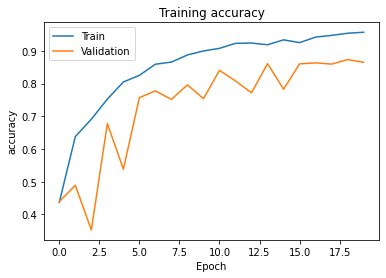

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
def plot_outs(history, name):
    plt.plot(history.history[name])
    plt.plot(history.history['val_'+name])
    plt.title('Training '+name)
    plt.ylabel(name)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    plt.clf()

plot_outs(history, 'accuracy')


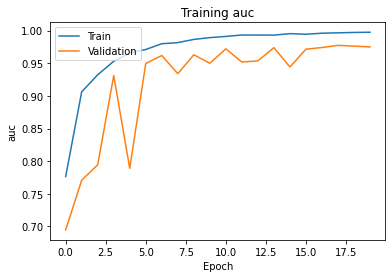

<Figure size 432x288 with 0 Axes>

In [15]:
plot_outs(history, 'auc')

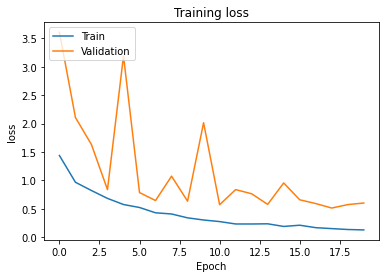

<Figure size 432x288 with 0 Axes>

In [16]:
plot_outs(history, 'loss')

In [17]:
from tensorflow.keras.layers import LSTM, Bidirectional
class RNN:
    def __init__(self, vocab_size, batch_size=256, epochs=20, embedding_dim=100, seq_len=30):
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size
        self.epochs = epochs
        self.seq_len = seq_len
        self.early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=0)
        self.reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=0.000001, verbose=0)
        self.model = self.build_model(vocab_size)

    def build_model(self, vocab_size):
        inputs = Input(shape=(self.seq_len,), dtype=np.int32)
        embedding = Embedding(input_dim=vocab_size, output_dim=self.embedding_dim, input_length=self.seq_len, trainable=True)
        model = embedding(inputs)
        model = Dropout(0.2)(model)

        model = Bidirectional(LSTM(4, input_shape=(self.seq_len, 1), return_sequences=True))(model)
        model = Dropout(0.2)(model)
        model = Bidirectional(LSTM(4, return_sequences=True))(model)
        model = Dropout(0.2)(model)
        model = Bidirectional(LSTM(4, return_sequences=True))(model)
        model = Dropout(0.2)(model)
        model = Bidirectional(LSTM(4))(model)
        outputs = Dense(6, activation='softmax')(model)
        return tf.keras.Model(inputs, outputs)

    def summary(self):
        return self.model.summary()

    def train(self, xtrain, xtest, ytrain, ytest):
        opt = Adam(learning_rate=0.01)
        self.model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
        history = self.model.fit(xtrain, ytrain, batch_size=self.batch_size, epochs=self.epochs, validation_data=(xtest, ytest), callbacks=[self.reduce_lr])
        return history

    def predict(self, data):
        return self.model.predict(data)


In [18]:
lstm = RNN(vocab_size)
history_lstm = lstm.train(xtrain, xtest, ytrain, ytest)

Epoch 1/20
63/63 [==============================] - 10s 45ms/step - loss: 1.4638 - accuracy: 0.4274 - auc: 0.7669 - val_loss: 1.1964 - val_accuracy: 0.5788 - val_auc: 0.8523
Epoch 2/20
63/63 [==============================] - 1s 24ms/step - loss: 0.8749 - accuracy: 0.6918 - auc: 0.9245 - val_loss: 0.6527 - val_accuracy: 0.7915 - val_auc: 0.9567
Epoch 3/20
63/63 [==============================] - 1s 24ms/step - loss: 0.4610 - accuracy: 0.8531 - auc: 0.9772 - val_loss: 0.4553 - val_accuracy: 0.8568 - val_auc: 0.9759
Epoch 4/20
63/63 [==============================] - 2s 24ms/step - loss: 0.2797 - accuracy: 0.9114 - auc: 0.9906 - val_loss: 0.3722 - val_accuracy: 0.8765 - val_auc: 0.9834
Epoch 5/20
63/63 [==============================] - 2s 24ms/step - loss: 0.2031 - accuracy: 0.9352 - auc: 0.9943 - val_loss: 0.3913 - val_accuracy: 0.8845 - val_auc: 0.9805
Epoch 6/20
63/63 [==============================] - 2s 25ms/step - loss: 0.1575 - accuracy: 0.9517 - auc: 0.9957 - val_loss: 0.3841 - 

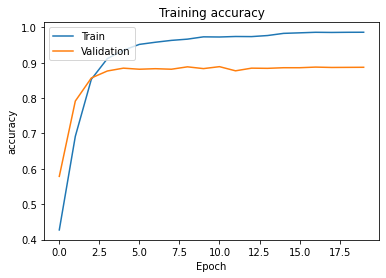

<Figure size 432x288 with 0 Axes>

In [19]:
plot_outs(history_lstm, 'accuracy')

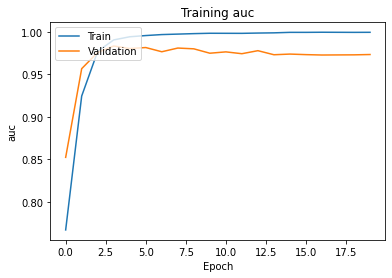

<Figure size 432x288 with 0 Axes>

In [20]:
plot_outs(history_lstm, 'auc')

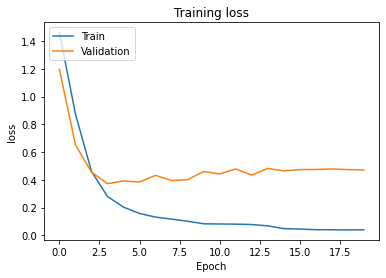

<Figure size 432x288 with 0 Axes>

In [21]:
plot_outs(history_lstm, 'loss')

# Transformer

In [22]:
from tensorflow.keras import layers
from tensorflow import keras

class Transformer(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(Transformer, self).__init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([layers.Dense(ff_dim, activation='relu'), layers.Dense(embed_dim),])
        self.layernorm1 = layers.LayerNormalization(epsilon=0.001)
        self.layernorm2 = layers.LayerNormalization(epsilon=0.001)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        x = self.attention(inputs, inputs)
        x = self.dropout1(x, training=training)
        out1 = self.layernorm1(inputs + x)
        y = self.ffn(x)
        y = self.dropout2(x, training=training)
        return self.layernorm2(out1 + y)

class Embed(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, glove_matrix=None):
        super(Embed, self).__init__()
        if glove_matrix is not None:
            self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, weights=[glove_matrix], trainable=False)
        else:
            self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [23]:
def build_transformer(maxlen=30, embed_dim=100, num_heads=4, ff_dim=128, vocab_size=vocab_size):
    trans = Transformer(embed_dim, num_heads, ff_dim, rate=0.3)
    embed = Embed(maxlen, vocab_size, embed_dim)
    input = Input(shape=(maxlen,))
    x = embed(input)
    x = trans(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(6, activation='softmax')(x)
    return keras.Model(input, output)

In [24]:
transformer = build_transformer()
opt = Adam(learning_rate=0.01)
transformer.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=0.000001, verbose=0)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=0)
history = transformer.fit(xtrain, ytrain, batch_size=256, epochs=20, validation_data=(xtest, ytest), callbacks=[early_stopping, reduce_lr])

Epoch 1/20
63/63 [==============================] - 2s 22ms/step - loss: 1.6290 - accuracy: 0.3105 - auc: 0.6964 - val_loss: 1.5801 - val_accuracy: 0.3338 - val_auc: 0.7148
Epoch 2/20
63/63 [==============================] - 1s 18ms/step - loss: 1.5876 - accuracy: 0.3313 - auc: 0.7104 - val_loss: 1.5742 - val_accuracy: 0.3338 - val_auc: 0.7166
Epoch 3/20
63/63 [==============================] - 1s 18ms/step - loss: 1.5152 - accuracy: 0.3739 - auc: 0.7444 - val_loss: 1.3412 - val_accuracy: 0.4885 - val_auc: 0.8114
Epoch 4/20
63/63 [==============================] - 1s 18ms/step - loss: 1.0605 - accuracy: 0.6139 - auc: 0.8864 - val_loss: 0.8956 - val_accuracy: 0.7003 - val_auc: 0.9223
Epoch 5/20
63/63 [==============================] - 1s 19ms/step - loss: 0.6579 - accuracy: 0.7782 - auc: 0.9554 - val_loss: 0.5927 - val_accuracy: 0.8065 - val_auc: 0.9652
Epoch 6/20
63/63 [==============================] - 1s 19ms/step - loss: 0.4483 - accuracy: 0.8543 - auc: 0.9779 - val_loss: 0.4715 - v

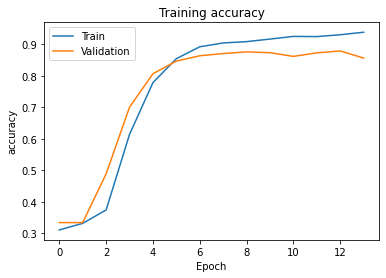

<Figure size 432x288 with 0 Axes>

In [25]:
plot_outs(history, 'accuracy')

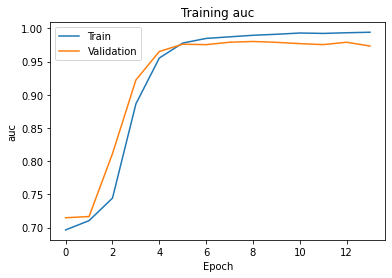

<Figure size 432x288 with 0 Axes>

In [26]:
plot_outs(history, 'auc')

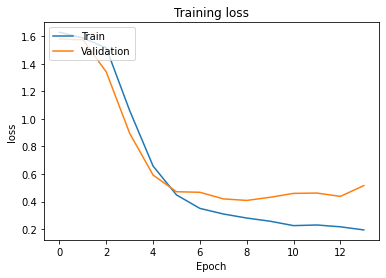

<Figure size 432x288 with 0 Axes>

In [27]:
plot_outs(history, 'loss')

# Results
CNN outperforms other two models. Transformer tends toward overfitting. Results might be different for others; I never seeded my runs.

In [28]:
from sklearn.metrics import classification_report
pred = cnn.predict(xtest)
pred.shape

(4000, 6)

In [29]:
final_df['label_raw'].value_counts().sort_index()

anger       2709
fear        2373
joy         6761
love        1641
sadness     5797
surprise     719
Name: label_raw, dtype: int64

In [30]:
cm = classification_report(np.argmax(ytest, axis=1), np.argmax(pred, axis=1), target_names=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'])

In [31]:
print(cm)

              precision    recall  f1-score   support

       anger       0.84      0.83      0.83       540
        fear       0.80      0.83      0.81       442
         joy       0.94      0.88      0.91      1335
        love       0.67      0.74      0.70       332
     sadness       0.94      0.93      0.94      1195
    surprise       0.58      0.78      0.66       156

    accuracy                           0.87      4000
   macro avg       0.79      0.83      0.81      4000
weighted avg       0.87      0.87      0.87      4000



## Song recommendation

In [32]:
comb_data.head()

,data,label,label_enc
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,4
2,im grabbing a minute to post i feel greedy wrong,anger,0
3,i am ever feeling nostalgic about the fireplac...,love,3
4,i am feeling grouchy,anger,0


In [33]:
def process_data(df):
    df_strat = df.groupby('label').apply(lambda x: x.sample(3)).droplevel(level=0)
    # print(df_strat)
    tokenized = tokenize_data(df_strat)
    sw_removed = remove_stopwords(tokenized)
    lemmatized = lemmatize(sw_removed)
    final_data = []
    # each l is a list of processed words
    for l in lemmatized:
        final_data.append(' '.join(l))
    d = {'data': final_data, 'data_raw': df_strat['data'], 'label': df_strat['label_enc'], 'label_raw': df_strat['label']}
    final_df = pd.DataFrame(data=d)
    return final_df
    

In [34]:
test_df = process_data(comb_data)
test_df

,data,data_raw,label,label_raw
697,really feel wrong patient,i really feel i was wronged as a patient,0,anger
6618,im marketer couldnt bother investigate make fe...,im a marketer and i couldnt be bothered to inv...,0,anger
4594,feel like fuck massively able fight suicidal,i feel like i ve fucked up massively for not b...,0,anger
8982,decide one lesson enough practise fair say fee...,i decided that this one lesson i had had was e...,1,fear
1738,believe im love believe youre love believe lif...,i believe that im love i believe that youre lo...,1,fear
2042,feel strange effect,i did not feel its strange effects no more,1,fear
833,im feel quite festive,im feeling quite festive,2,joy
6234,feel like haiku pleasant note end,i feel like a haiku is a pleasant note to end on,2,joy
5144,didnt sleep quite well last night still feel q...,i didnt sleep quite as well last night but i s...,2,joy
3609,also feel one music school really supportive,i also feel that no one in the music school is...,3,love


In [107]:
final_df.head()

,data,label,label_raw
0,didnt feel humiliate,4,sadness
1,go feel hopeless damn hopeful around someone c...,4,sadness
2,im grab minute post feel greedy wrong,0,anger
3,ever feel nostalgic fireplace know still property,3,love
4,feel grouchy,0,anger


In [36]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(final_df['data'])
test_data = pad_sequences(tokenizer.texts_to_sequences(test_df['data']), maxlen=30)

In [37]:
probs = np.argmax(cnn.predict(test_data), axis=1)

In [38]:
probs_trans = np.argmax(transformer(test_data), axis=1)

In [39]:
from sklearn.metrics import accuracy_score
print(accuracy_score(list(test_df['label']), probs))
print(accuracy_score(list(test_df['label']), probs_trans))

0.9444444444444444
1.0


1.0 = perfect accuracy
## Song data

In [47]:
song_data = pd.read_csv('data/songs.csv', usecols=['song_name', 'genre', 'valence', 'energy', 'danceability', 'loudness'])

C:\Users\tg584\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [48]:
print(song_data.shape)
song_data.head()

(42305, 6)


,danceability,energy,loudness,valence,genre,song_name
0,0.831,0.814,-7.364,0.3890,Dark Trap,Mercury: Retrograde
1,0.719,0.493,-7.230,0.1240,Dark Trap,Pathology
2,0.850,0.893,-4.783,0.0391,Dark Trap,Symbiote
3,0.476,0.781,-4.710,0.1750,Dark Trap,ProductOfDrugs (Prod. The Virus and Antidote)
4,0.798,0.624,-7.668,0.5910,Dark Trap,Venom


In [75]:
song_data_clean = song_data.dropna()

In [76]:
song_data_clean['genre'].value_counts()

Underground Rap    5875
Dark Trap          4578
Hiphop             3022
RnB                2099
Trap Metal         1956
Rap                1848
Emo                1680
Pop                 461
Name: genre, dtype: int64

In [77]:
song_data_clean['energy'].min(), song_data_clean['energy'].max()

(0.000243, 0.999)

In [78]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
le = LabelEncoder()
sc = MinMaxScaler()
cols = ['danceability', 'energy', 'loudness', 'valence']
song_data_clean['genre_enc'] = le.fit_transform(song_data_clean['genre'])
song_data_clean[cols] = sc.fit_transform(song_data_clean[cols])

C:\Users\tg584\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\tg584\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [79]:
song_data_clean.head()

,danceability,energy,loudness,valence,genre,song_name,genre_enc
0,0.829884,0.814770,0.712039,0.383990,Dark Trap,Mercury: Retrograde,0
1,0.708527,0.493370,0.715710,0.107776,Dark Trap,Pathology,0
2,0.850471,0.893868,0.782742,0.019283,Dark Trap,Symbiote,0
3,0.445227,0.781729,0.784742,0.160934,Dark Trap,ProductOfDrugs (Prod. The Virus and Antidote),0
4,0.794127,0.624533,0.703712,0.594538,Dark Trap,Venom,0


For n_clusters=2, SSE is 1721.2149797742845, labels is [1 0 0 ... 1 1 1]
For n_clusters=3, SSE is 1333.4552203085457, labels is [0 2 1 ... 0 0 0]
For n_clusters=4, SSE is 1135.204008711396, labels is [3 0 2 ... 3 1 1]
For n_clusters=5, SSE is 994.7427473191192, labels is [1 2 0 ... 1 3 3]
For n_clusters=6, SSE is 884.8502115500665, labels is [2 2 2 ... 4 1 5]
For n_clusters=7, SSE is 803.6416156515635, labels is [0 6 0 ... 5 3 0]
For n_clusters=8, SSE is 748.7753988187096, labels is [2 0 7 ... 2 1 2]
For n_clusters=9, SSE is 699.3833542206853, labels is [5 8 7 ... 5 3 5]


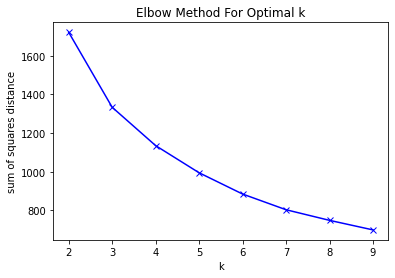

In [81]:
sse = []
for i in range(2, 10):
    kc = KMeans(n_clusters=i, n_init=20)
    kc = kc.fit(song_data_clean.drop(['song_name', 'genre', 'genre_enc'], axis=1))
    sse.append(kc.inertia_)
    print(f'For n_clusters={i}, SSE is {kc.inertia_}')
plt.plot(range(2,10), sse, 'bx-')
plt.xlabel('k')
plt.ylabel('sum of squares distance')
plt.title('Elbow Method For Optimal k')
plt.show()

In [82]:
kc = KMeans(n_clusters=6, n_init=20)
song_data_clean['clusters'] = kc.fit_predict(song_data_clean.drop(['song_name', 'genre', 'genre_enc'], axis=1))

C:\Users\tg584\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [83]:
song_data_clean.head()

,danceability,energy,loudness,valence,genre,song_name,genre_enc,clusters
0,0.829884,0.814770,0.712039,0.383990,Dark Trap,Mercury: Retrograde,0,3
1,0.708527,0.493370,0.715710,0.107776,Dark Trap,Pathology,0,3
2,0.850471,0.893868,0.782742,0.019283,Dark Trap,Symbiote,0,3
3,0.445227,0.781729,0.784742,0.160934,Dark Trap,ProductOfDrugs (Prod. The Virus and Antidote),0,2
4,0.794127,0.624533,0.703712,0.594538,Dark Trap,Venom,0,1


In [103]:
print(list(zip(test_df.label.unique(), test_df.label_raw.unique())))
centers = kc.cluster_centers_
print(centers)
# based on subjective feeling of how to map to emotions: in general, low valence -> less strong emotions
emo2center = {(0, 'anger'): 0, (1, 'fear'): 2, (2, 'joy'): 5, (3, 'love'): 3, (4, 'sadness'): 4, (5, 'surprise'): 1}

[(0, 'anger'), (1, 'fear'), (2, 'joy'), (3, 'love'), (4, 'sadness'), (5, 'surprise')]
[[0.5594681  0.82319268 0.77347656 0.51478891]
 [0.77265109 0.54842141 0.68766532 0.54116447]
 [0.45668647 0.79343483 0.75692375 0.17302053]
 [0.77344225 0.60034201 0.71563595 0.24057601]
 [0.54175345 0.42271159 0.62557935 0.16837439]
 [0.76658413 0.7472778  0.75370333 0.77585153]]


In [89]:
def process_song_data(df):
    # print(df_strat)
    df.rename(columns={'song_name': 'data'}, inplace=True)
    tokenized = tokenize_data(df)
    sw_removed = remove_stopwords(tokenized)
    lemmatized = lemmatize(sw_removed)
    final_data = []
    # each l is a list of processed words
    for l in lemmatized:
        final_data.append(' '.join(l))
    df['clean_name'] = final_data
    return df
clean_song_data = process_song_data(song_data_clean)

C:\Users\tg584\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [95]:
clean_song_data.head()

,danceability,energy,loudness,valence,genre,data,genre_enc,clusters,clean_name
0,0.829884,0.814770,0.712039,0.383990,Dark Trap,Mercury: Retrograde,0,3,mercury retrograde
1,0.708527,0.493370,0.715710,0.107776,Dark Trap,Pathology,0,3,pathology
2,0.850471,0.893868,0.782742,0.019283,Dark Trap,Symbiote,0,3,symbiote
3,0.445227,0.781729,0.784742,0.160934,Dark Trap,ProductOfDrugs (Prod. The Virus and Antidote),0,2,productofdrugs prod virus antidote
4,0.794127,0.624533,0.703712,0.594538,Dark Trap,Venom,0,1,venom


In [104]:
df_anger = clean_song_data[clean_song_data['clusters'] == 0]
df_fear = clean_song_data[clean_song_data['clusters'] == 2]
df_joy = clean_song_data[clean_song_data['clusters'] == 5]
df_love = clean_song_data[clean_song_data['clusters'] == 3]
df_sadness = clean_song_data[clean_song_data['clusters'] == 4]
df_surprise = clean_song_data[clean_song_data['clusters'] == 1]

In [96]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [111]:
list_clustered_dfs = [df_anger, df_fear, df_joy, df_love, df_sadness, df_surprise]

In [106]:
emo2center.keys()

dict_keys([(0, 'anger'), (1, 'fear'), (2, 'joy'), (3, 'love'), (4, 'sadness'), (5, 'surprise')])

In [112]:
for ind, prob in enumerate(probs_trans):
    print(f"Raw input string: {test_df.iloc[ind]['data_raw']}")
    print(f'Predicted sentiment: {list(emo2center.keys())[prob][1]}, /////// Actual sentiment: {test_df.iloc[ind]["label_raw"]}')
    chosen_df = list_clustered_dfs[prob]
    print('-----Song recommendations-----')
    chosen_df = chosen_df.sample(n=3)
    for i, row in chosen_df.iterrows():
        print(f'Name: {row["data"]}, Genre: {row["genre"]}')
    print("---" * 30)

Raw input string: i really feel i was wronged as a patient
Predicted sentiment: anger, /////// Actual sentiment: anger
-----Song recommendations-----
Name: Gnarly (feat. Lil Pump), Genre: Underground Rap
Name: Swang, Genre: Hiphop
Name: All I Wear Is Black, Genre: Emo
---------------------------------------------
Raw input string: im a marketer and i couldnt be bothered to investigate further which makes me feel that consumers probably cant be bothered either
Predicted sentiment: anger, /////// Actual sentiment: anger
-----Song recommendations-----
Name: M.I.N.D, Genre: Dark Trap
Name: Oops (I'm Sorry), Genre: Underground Rap
Name: Suga Suga, Genre: RnB
---------------------------------------------
Raw input string: i feel like i ve fucked up massively for not being able to fight off being suicidal
Predicted sentiment: anger, /////// Actual sentiment: anger
-----Song recommendations-----
Name: Picasso, Genre: Underground Rap
Name: Rubble Kingz, Genre: Dark Trap
Name: Warm Me Up, Genre:

In [116]:
for ind, prob in enumerate(probs_trans):
    print(f"Raw input string: {test_df.iloc[ind]['data_raw']}")
    print(f'Predicted sentiment: {list(emo2center.keys())[prob][1]}, /////// Actual sentiment: {test_df.iloc[ind]["label_raw"]}')
    chosen_df = list_clustered_dfs[prob]
    all_text = chosen_df.append({'clean_name': test_df.iloc[ind]['data_raw']}, ignore_index=True)
    tfidf = TfidfVectorizer(stop_words='english')
    tf_mat = tfidf.fit_transform(chosen_df['clean_name'])
    cos_sim = cosine_similarity(tf_mat, tf_mat)
    simi = list(enumerate(cos_sim[ind]))
    simi = sorted(simi, key=lambda x: x[1], reverse=True)
    best = simi[1:4]
    inds = [x[0] for x in best]
    print('-----Song recommendations-----')
    print(chosen_df.iloc[inds][['data', 'genre']])
    print("---" * 30)

Raw input string: i really feel i was wronged as a patient
Predicted sentiment: anger, /////// Actual sentiment: anger
-----Song recommendations-----
                                           data            genre
6468   Nightmare Choir (I Been Asleep Too Long)  Underground Rap
10648  Nightmare Choir (I Been Asleep Too Long)       Trap Metal
11807                                 Nightmare       Trap Metal
------------------------------------------------------------------------------------------
Raw input string: im a marketer and i couldnt be bothered to investigate further which makes me feel that consumers probably cant be bothered either
Predicted sentiment: anger, /////// Actual sentiment: anger
-----Song recommendations-----
                    data            genre
2261   Champion of Death        Dark Trap
5055   Champion Of Death  Underground Rap
10671  Champion Of Death       Trap Metal
------------------------------------------------------------------------------------------
